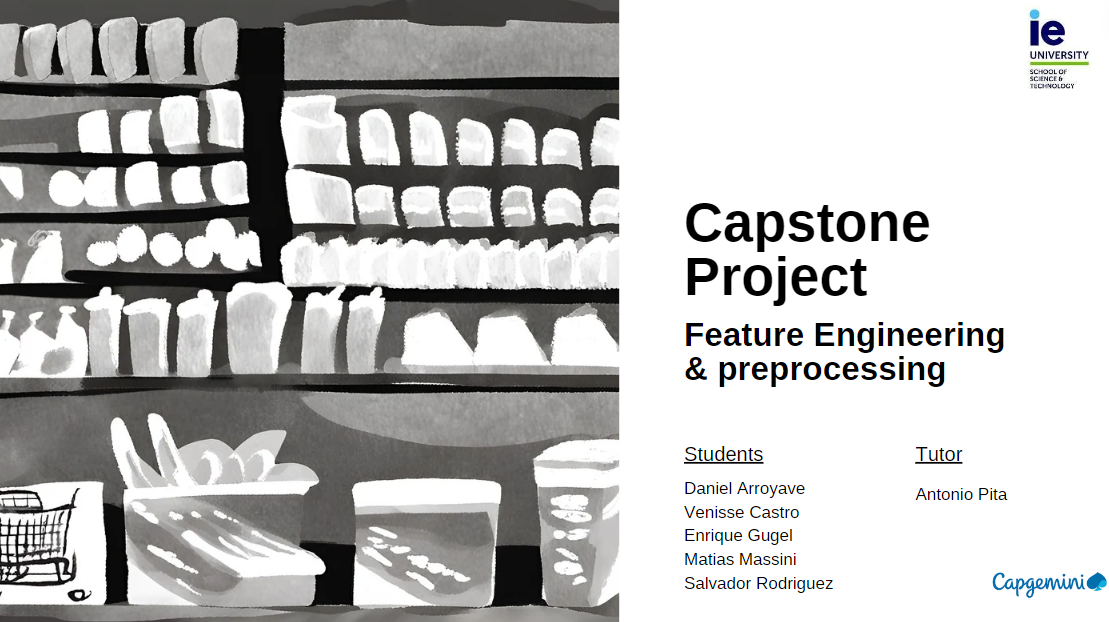

The purpose of this notebook is to perform feature engineering and preprocessing to obtain the final dataset to develop our recommendation tool.

# **1.   Libraries to be imported**



In [ ]:
import os
from google.colab import drive
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import KFold

from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# **2.   Import Data**

We will create a Dataframe with each of the excel files providede by Capgemini



In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<mark>**IMPORTANT: Update the route the access the csv's**<mark>

* Route is the path to access the original csv's
* Destination is the path to save the datasets

In [ ]:
# Update the route to access the data:
#route = '/content/drive/My Drive/CAPSTONE/Dataset_cleaned_merged/df_merged_version.csv'
#destination = '/content/drive/My Drive/CAPSTONE/Dataset_cleaned_merged/'

#in case you accessing the google shared drive use this and discard the previous by adding a # before and deleting the # in the next line:
route = '/content/drive/Shared drives/Capstone/Dataset_cleaned_merged/df_merged_version.csv'
destination = '/content/drive/Shared drives/Capstone/Dataset_cleaned_merged'

In [ ]:
# Path to the CSV file
file_path = route

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

df.head(5)


,id_orden,id_producto,incluido_orden_carrito,reordenado,nombre_producto,id_pasillo,id_departamento,pasillo,departamento
0,1,49302,1,1,EL YOGUR DE BULGARIA,120.0,16.0,YOGUR,HUEVOS Y LÁCTEOS
1,1,11109,2,1,4% ORGÁNICO QUESO GRASA DE LECHE LECHE ENTERA ...,108.0,16.0,OTROS QUESOS CREMAS,HUEVOS Y LÁCTEOS
2,1,10246,3,0,CORAZONES DE APIO ORGÁNICOS,83.0,4.0,VEGETALES FRESCOS,FRUTAS Y VERDURAS
3,1,49683,4,0,KIRBY PEPINO,83.0,4.0,VEGETALES FRESCOS,FRUTAS Y VERDURAS
4,1,43633,5,1,LAS SARDINAS LIGERAMENTE AHUMADO EN ACEITE DE ...,95.0,15.0,MARISCOS CARNE ENLATADA,PRODUCTOS ENLATADOS


In [ ]:
df['id_orden'].nunique()

131153

In [ ]:
num_unique_products = df['id_producto'].nunique()

num_unique_products = df['nombre_producto'].nunique()

print(f"Number of unique nombre_producto values: {num_unique_products}")

print(f"Number of unique id_producto values: {num_unique_products}")

Number of unique nombre_producto values: 38403
Number of unique id_producto values: 38403


In [ ]:
# Create a mapping of product names to their first occurrence of the product code
name_to_first_code = df.drop_duplicates(subset=['nombre_producto']).set_index('nombre_producto')['id_producto'].to_dict()

# Replace product codes using the mapping
df['id_producto'] = df['nombre_producto'].map(name_to_first_code)

In [ ]:
num_unique_products = df['id_producto'].nunique()

num_unique_products = df['nombre_producto'].nunique()

print(f"Number of unique nombre_producto values: {num_unique_products}")

print(f"Number of unique id_producto values: {num_unique_products}")

Number of unique nombre_producto values: 38403
Number of unique id_producto values: 38403


# **3.Data Preprocessing**

First let's proceed with **data normalization** for the order in which the items where included in the cart.

Given that "incluido_orden_carrito" represents a sequential order within a cart, and typically ranges from 1 to the total number of items in the cart, Min-Max Scaler is generally more appropriate. This will preserve the relative ordering and map the feature to a [0, 1] range, which is easy to interpret and consistent across different carts.

In [ ]:
# Initialize the scaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling to the 'incluido_orden_carrito' feature
df['incluido_orden_carrito_normalized'] = scaler.fit_transform(df[['incluido_orden_carrito']])

print(df[['incluido_orden_carrito', 'incluido_orden_carrito_normalized']].head(5))


   incluido_orden_carrito  incluido_orden_carrito_normalized
0                       1                           0.000000
1                       2                           0.012821
2                       3                           0.025641
3                       4                           0.038462
4                       5                           0.051282


Now we will **encode** the categorical features. As we have the id_codes and the descriptions, we will proceed with the descriptions as it will be much easier to understand the meaning of each feature.

In [ ]:
# Encoding categorical features
label_encoder = LabelEncoder()

df['pasillo_encoded'] = label_encoder.fit_transform(df['pasillo'])
df['departamento_encoded'] = label_encoder.fit_transform(df['departamento'])

# One-Hot Encoding for 'pasillo'
one_hot_encoder = OneHotEncoder(sparse=False)

pasillo_encoded = one_hot_encoder.fit_transform(df[['pasillo']])
pasillo_encoded_df = pd.DataFrame(pasillo_encoded, columns=one_hot_encoder.get_feature_names_out(['pasillo']))

# One-Hot Encoding for 'departamento'
depto_encoded = one_hot_encoder.fit_transform(df[['departamento']])
depto_encoded_df = pd.DataFrame(depto_encoded, columns=one_hot_encoder.get_feature_names_out(['departamento']))

# Reset index to ensure proper concatenation
df.reset_index(drop=True, inplace=True)

pasillo_encoded_df.reset_index(drop=True, inplace=True)
depto_encoded_df.reset_index(drop=True, inplace=True)

# Concatenate the One-Hot encoded columns to the original DataFrame
df = pd.concat([df, pasillo_encoded_df], axis=1)
df = pd.concat([df, depto_encoded_df], axis=1)

df.head(5)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,id_orden,id_producto,incluido_orden_carrito,reordenado,nombre_producto,id_pasillo,id_departamento,pasillo,departamento,incluido_orden_carrito_normalized,...,departamento_INTERNACIONALES,departamento_MARISCOS,departamento_MASCOTAS,departamento_MERIENDAS,departamento_OTROS,departamento_PANADERÍA,departamento_PASTAS Y PRODUCTOS SECOS,departamento_PRODUCTOS A GRANEL,departamento_PRODUCTOS ENLATADOS,departamento_SIN CATALOGAR
0,1,49302,1,1,EL YOGUR DE BULGARIA,120.0,16.0,YOGUR,HUEVOS Y LÁCTEOS,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,11109,2,1,4% ORGÁNICO QUESO GRASA DE LECHE LECHE ENTERA ...,108.0,16.0,OTROS QUESOS CREMAS,HUEVOS Y LÁCTEOS,0.012821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,10246,3,0,CORAZONES DE APIO ORGÁNICOS,83.0,4.0,VEGETALES FRESCOS,FRUTAS Y VERDURAS,0.025641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,49683,4,0,KIRBY PEPINO,83.0,4.0,VEGETALES FRESCOS,FRUTAS Y VERDURAS,0.038462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,43633,5,1,LAS SARDINAS LIGERAMENTE AHUMADO EN ACEITE DE ...,95.0,15.0,MARISCOS CARNE ENLATADA,PRODUCTOS ENLATADOS,0.051282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df.columns

Index(['id_orden', 'id_producto', 'incluido_orden_carrito', 'reordenado',
       'nombre_producto', 'id_pasillo', 'id_departamento', 'pasillo',
       'departamento', 'incluido_orden_carrito_normalized',
       ...
       'departamento_INTERNACIONALES', 'departamento_MARISCOS',
       'departamento_MASCOTAS', 'departamento_MERIENDAS', 'departamento_OTROS',
       'departamento_PANADERÍA', 'departamento_PASTAS Y PRODUCTOS SECOS',
       'departamento_PRODUCTOS A GRANEL', 'departamento_PRODUCTOS ENLATADOS',
       'departamento_SIN CATALOGAR'],
      dtype='object', length=167)

# **Feature Engineering**

In [ ]:
# Total Orders for a Product
df['total_orders_per_product'] = df.groupby('id_producto')['id_orden'].transform('count')

# Total Reorders for a Product
df['total_reorders_per_product'] = df.groupby('id_producto')['reordenado'].transform('sum')

# Reorder Rate per Product
df['reorder_rate_per_product'] = df['total_reorders_per_product'] / df['total_orders_per_product']

# Order Size
df['order_size'] = df.groupby('id_orden')['id_orden'].transform('count')

# Position in Order
df['position_in_order'] = df['incluido_orden_carrito_normalized'] / df['order_size']

# Product Popularity in Department
df['product_popularity_in_department'] = df.groupby(['id_departamento', 'id_producto'])['id_orden'].transform('count')

# Product Popularity in Aisle
df['product_popularity_in_aisle'] = df.groupby(['id_pasillo', 'id_producto'])['id_orden'].transform('count')

Let's consider normalization for these new features:
* Total Orders for a Product: Since this feature can vary significantly between products, **normalization can help** bring it to a comparable scale with other features.
* Total Reorders for a Product: Similarly, this feature might have a wide range of values, so **normalization is beneficial**.
* Reorder Rate per Product: This feature is already a ratio, generally ranging between 0 and 1, so it might **not need** normalization.
* Order Size: This feature can vary widely depending on the number of items in each order, making **normalization useful**.
* Position in Order: This feature is **already normalized** as a ratio of the order size, so it typically does not need further normalization.
* Product Popularity in Department: This feature can vary widely, so **normalization is recommended**.
* Product Popularity in Aisle: Similar to product popularity in the department, **normalization is beneficial**.

In [ ]:
# Features to be normalized
features_to_normalize = [
    'total_orders_per_product',
    'total_reorders_per_product',
    'order_size',
    'product_popularity_in_department',
    'product_popularity_in_aisle'
]

# Normalize these features
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

In [ ]:
df['id_orden'].nunique()

131153

# **6. Final dataset export**

In [ ]:
# Define the directory path for the cleaned data folder
cleaned_data_folder = destination

# Check if the directory exists, if not, create it
if not os.path.exists(cleaned_data_folder):
    os.makedirs(cleaned_data_folder)

# Define the file path for the CSV file
csv_file_path = os.path.join(cleaned_data_folder, 'df_final_version.csv')

# Export the cleaned DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

# Print confirmation message
print(f"Cleaned DataFrame exported to: {csv_file_path}")

Cleaned DataFrame exported to: /content/drive/My Drive/CAPSTONE/Dataset_cleaned_merged/df_final_version.csv
